In [1]:
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 

In [7]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads      = heads
        self.head_dim   = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        )

        self.values  = nn.Linear(self.embed_size, self.embed_size, bias=False)
        self.keys    = nn.Linear(self.embed_size, self.embed_size, bias=False)
        self.queries = nn.Linear(self.embed_size, self.embed_size, bias=False)
        self.fc_out  = nn.Linear(heads * self.head_dim, embed_size)
        

    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]        
        values  = self.values(values)  # (N, value_len, heads, head_dim)
        keys    = self.keys(keys)  # (N, key_len, heads, head_dim)
        queries = self.queries(query)  # (N, query_len, heads, heads_dim)

        # Multi head
        # [N, len, embed_size] --> [N, len, heads, head_dim]
        values  = values.reshape(N, value_len, self.heads, self.head_dim)
        keys    = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries   = queries.reshape(N, query_len, self.heads, self.head_dim)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim = 3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)

        return out

In [8]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1     = nn.LayerNorm(embed_size)
        self.norm2     = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)


    def forward(self, value, key, query):
        attention = self.attention(value, key, query)

        x       = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out     = self.dropout(self.norm2(forward + x))
        return out

In [9]:
class Encoder(nn.Module):
    def __init__(
        self,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
        batch_size
    ):

        super(Encoder, self).__init__()
        self.embed_size         = embed_size
        self.device             = device
        self.pos_enc = PositionalEncoding(batch_size, embed_size, max_length)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)
        

    def forward(self, x):
        
        N, seq_length = x.shape[:2]
        
        out = self.pos_enc(x)

        for layer in self.layers:
            out = layer(out, out, out)

        return out

In [10]:
class PositionalEncoding(nn.Module):

    def __init__(self, batch_size, embed_size, max_len = 5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(batch_size, max_len, embed_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1).unsqueeze(0)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-math.log(10000.0) / embed_size))
        pe[:, :, 0::2] = torch.sin(position * div_term)
        pe[:, :, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)
        

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

In [12]:
class Transformer(nn.Module):
  
    def __init__(
        self,
        embed_size = 512,
        num_layers = 6,
        forward_expansion = 4,
        heads = 8,
        dropout = 0,
        max_length = 100,
        batch_size = 512,
        device = "cpu"
    ):

        super(Transformer, self).__init__()

        self.encoder = Encoder(
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
            batch_size
        )

        # Decoder only does Linear Transformation.
        self.decoder = nn.Linear(embed_size, 1)
      
        self.device = device


    def forward(self, src):
        enc_src = self.encoder(src)
        out = self.decoder(enc_src)
        
        return out

In [14]:
class PriceDataset(Dataset):
    
    def __init__(self, data, window_size, scaler, after_day):
        
        self.data = mm.fit_transform(data)
        self.window_size = window_size
        self.after_day = after_day

        self.x, self.y = self.getSeriesData(self.data, window_size, after_day)


    def __len__(self):
        return len(self.data) - self.window_size - self.after_day
    

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    

    # Learning Period, Prediction Period
    def getSeriesData(self, data, window_size, after_day):
        n_pairs = len(data) - window_size - after_day # Number of (x, y)
        xlist = [data[i:i+window_size] for i in range(n_pairs)]
        ylist = [data[i+window_size+after_day] for i in range(n_pairs)]
        
        x = torch.Tensor(xlist)
        y = torch.Tensor(ylist)

        return x, y

In [19]:
df = pd.read_csv('data_final.csv')
df = df.drop(['time'], axis=1)

mm= MinMaxScaler()

train, test = train_test_split(df, test_size=0.4, shuffle=False)
valid, test = train_test_split(test, test_size=0.5, shuffle=False)

window_size = 30
after_day = 3
batch_size = 64
 
train_dataset = PriceDataset(train, window_size, mm, after_day)
valid_dataset = PriceDataset(valid, window_size, mm, after_day)
test_dataset  = PriceDataset(test, window_size, mm, after_day)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [23]:
# Adjust Parameters
embed_size        = 68
num_layers        = 4
forward_expansion = 4
heads             = 4
dropout           = 0.01
max_length        = window_size
clip = 5

weight_decay      = 5e-4
factor            = 0.9
patience          = 10
init_lr           = 0.0001
adam_eps          = 5e-9
epochs            = 300

device            = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = Transformer(embed_size=embed_size,
                    num_layers=num_layers,
                    forward_expansion=forward_expansion,
                    heads = heads,
                    dropout = dropout,
                    device = device,
                    batch_size=batch_size,
                    max_length = max_length).to(device)

model.to(device)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')


def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
model.apply(initialize_weights)

# Optimizing Learning Process with Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = init_lr, weight_decay = weight_decay, eps = adam_eps)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 verbose = True,
                                                 factor = factor,
                                                 patience = patience)

criterion = torch.nn.MSELoss()

In [ ]:
model.train()

counter = 0
print_every = 500

for e in range(epochs):
    running_loss = 0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y = y[:, 0].unsqueeze(1)
        model.zero_grad()

        output = model(x)
        
        loss = criterion(output.squeeze(), y.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        running_loss += loss.item()
        
        # Loss Stats
        if counter % print_every == 0:
          
            # Get validation loss
            val_losses = []
            model.eval()

            for inputs, labels in valid_loader:
                labels = labels[:, 0].unsqueeze(1)

                inputs, labels = inputs.to(device), labels.to(device)

                output = model(inputs)
                val_loss = criterion(output.squeeze(), labels.float())
                val_loss = torch.sqrt(val_loss)

                val_losses.append(val_loss.item())

            model.train()

            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
        
    else:
        print(f"Training loss: {running_loss/len(train_loader)}")

In [ ]:
test_RMSE = []
outputs = []
actual = []

model.eval()

sum = 0
number = 0

for inputs, labels in test_loader: 
  labels = labels[:, 0].unsqueeze(1)
  inputs, labels = inputs.to(device), labels.to(device)
  output = model(inputs)

  outputs.extend(output[:, 0].detach().cpu().numpy())
  actual.extend(labels.detach().cpu().numpy())

  test_loss = criterion (output.squeeze(), labels.float())
  test_loss = torch.sqrt(test_loss)
  test_RMSE.append(test_loss.item())

  sum += np.mean(test_RMSE)
  number += 1

  print(np.mean(test_RMSE))
  
average = sum / number
print("\n average : {} \n".format(average)) 

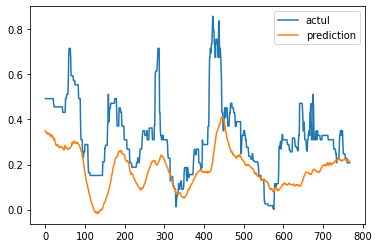

In [ ]:
fix, ax = plt.subplots()
ax.plot(actual, label = 'actul')
ax.plot(outputs, label = 'prediction')

plt.legend()
plt.show()